# I) General

## 1. Importations

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import codecs
import re
import os.path
import random
import string
import re
import unicodedata
from time import time

import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
import sklearn.naive_bayes as nb

from wordcloud import WordCloud

import warnings
warnings.filterwarnings("ignore")

# II) First data set french presidents

## 1. Data visualization

In [2]:
def load_pres(fname):
    alltxts = []
    alllabs = []
    s=codecs.open(fname, 'r','utf-8')
    while True:
        txt = s.readline()
        if(len(txt))<5:
            break
        lab = re.sub(r"<[0-9]*:[0-9]*:(.)>.*","\\1",txt)
        txt = re.sub(r"<[0-9]*:[0-9]*:.>(.*)","\\1",txt)
        if lab.count('M') >0:
            alllabs.append(-1)
        else: 
            alllabs.append(1)
        alltxts.append(txt)
    return alltxts,alllabs

In [3]:
def preprocessing(X):
    res = []
    for doc in X:
        punc = string.punctuation
        punc += '\n\r\t'
        doc = doc.translate(str.maketrans(punc, ' ' * len(punc)))
        doc = unicodedata.normalize('NFD', doc).encode('ascii', 'ignore').decode("utf-8")
        doc = doc.lower()
        doc = re.sub('[0-9]+', '', doc)
        res.append(doc)
    return np.array(res)

def formal(X):
    stemmer = SnowballStemmer(language='french')
#     nltk.download('stopwords')
    res = []
    stop = stopwords.words('french')
    for doc in X:
        new_doc = ""
        for w in doc.split():
            if w not in stop:
                new_doc += w + " "
        new_doc = [stemmer.stem(X) for X in new_doc.split()]
        new_doc = " ".join(new_doc)
        res.append(new_doc)
    return res

def flatten(A):
    rt = []
    for i in A:
        if isinstance(i,list): 
            rt.extend(flatten(i))
        else: 
            rt.append(i)
    return rt

In [4]:
fname = "../TME1/data/corpus.tache1.learn.utf8"
alltxts, alllabs = load_pres(fname)
X = np.array(alltxts)[:1000]
Y = np.array(alllabs)[:1000]
X_preprocess = preprocessing(X)
X_train = formal(X_preprocess)

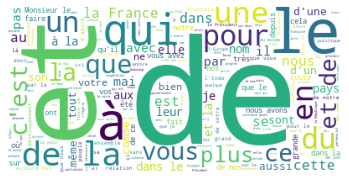

In [5]:
words = "".join(flatten(X))
wordcloud = WordCloud(background_color='white', max_words=200).generate(words)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

[9.99995000e-06 9.99995000e-06 9.99995000e-06 ... 6.56948143e+00
 6.72022017e+00 7.12689082e+00]
['insiste' 'malabar' 'malentendus' ... 'et' 'la' 'de']


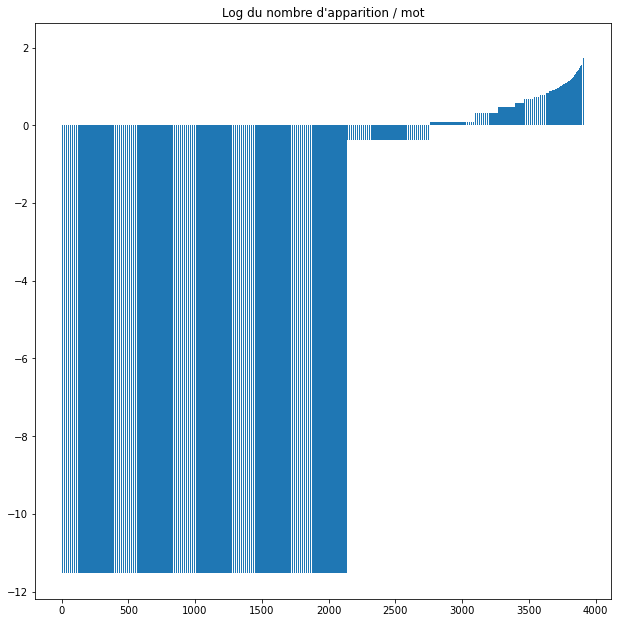

In [6]:
words = "".join(flatten(X_preprocess))
unique_words, count = np.unique(words.split(), return_counts=True)
count = np.log(count+1e-5)

count_sort_ind = np.argsort(count)
unique_words = unique_words[count_sort_ind]
count = np.sort(count)
print(count)
print(unique_words)

fig = plt.figure(figsize=(8,8))
ax = fig.add_axes([0,0,1,1])
ax.bar(np.arange(len(count)),np.log(count))
plt.title("Log du nombre d'apparition / mot")
plt.show()

[   1    1    1 ...  713  829 1245]
['insiste' 'malabar' 'malentendus' ... 'et' 'la' 'de']


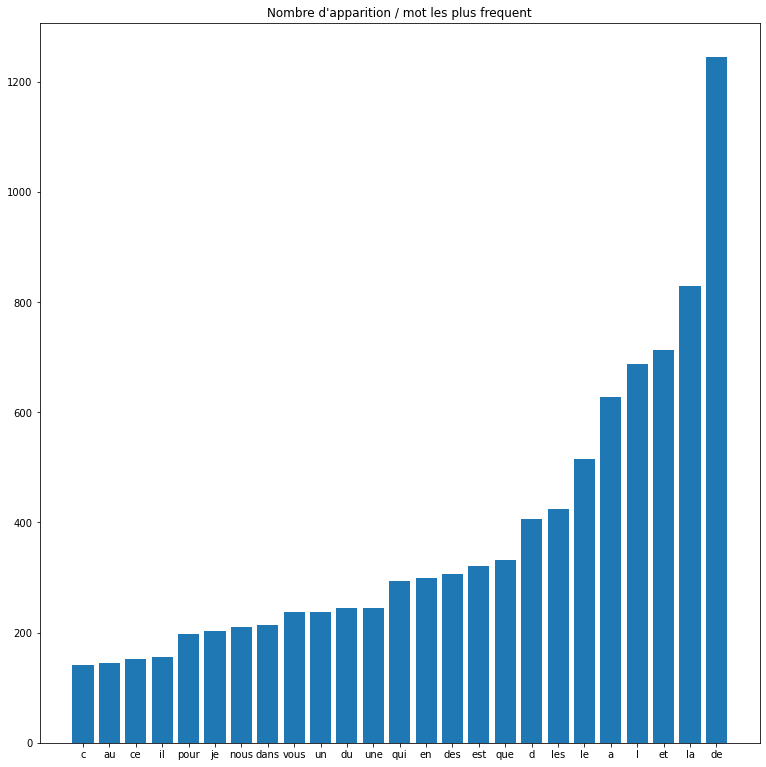

In [7]:
unique_words, count = np.unique(words.split(), return_counts=True)

count_sort_ind = np.argsort(count)
unique_words = unique_words[count_sort_ind]
count = np.sort(count)
print(count)
print(unique_words)

fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([0,0,1,1])
ax.bar(unique_words[len(count)-25:],count[len(count)-25:])
plt.title("Nombre d'apparition / mot les plus frequent")
plt.show()

## 2. Features and model selection

In [8]:
def naive_balancing(X, Y):
    label, count = np.unique(Y, return_counts=True)
    idx_pos = np.where(Y == 1, True, False)
    Y_pos = Y[idx_pos]
    Y_pos = Y_pos[:count.min()]
    idx_neg = np.where(Y == -1, True, False)
    Y_neg = Y[idx_neg]
    new_Y = np.concatenate((Y_pos, Y_neg))
    new_X = np.concatenate((X[:count.min()], X[idx_neg]))    
    tmp = list(zip(new_X, new_Y))
    random.shuffle(tmp)
    new_X, new_Y = zip(*tmp)  
    label, count = np.unique(new_Y, return_counts=True)
    print(label, count)
    return new_X, new_Y

def get_all_data_vectorized(X, X_test, Y, Y_test, vectorizer, transformer=None):
    X_vector = vectorizer.fit_transform(X)
    if transformer is not None:
        transformer = transformer.fit(X_vector)
        X_final = transformer.transform(X_vector)
    else:
        X_final = X_vector
    X_test_vector = vectorizer.transform(X_test)
    return X_final, X_test_vector, Y, Y_test

def get_inf_acc(predictions, Y_test):
    idx_inf = np.where(predictions==-1, True, False)
    tmp_pred = predictions[idx_inf]
    tmp_real = Y_test[idx_inf]
    cpt = 0
    for i in range(len(tmp_pred)):
        if tmp_pred[i] == tmp_real[i]:
            cpt += 1
    return np.round((cpt/len(tmp_pred))*100, 2)

def get_sup_acc(predictions, Y_test):
    idx_inf = np.where(predictions==1, True, False)
    tmp_pred = predictions[idx_inf]
    tmp_real = Y_test[idx_inf]
    cpt = 0
    for i in range(len(tmp_pred)):
        if tmp_pred[i] == tmp_real[i]:
            cpt += 1
    return np.round((cpt/len(tmp_pred))*100, 2)

def display_infos(clf, X_test, Y_test):
    # Check le nombre de predictions pour chaque label
    predictions = clf.predict(X_test)
    unique, counts = np.unique(predictions, return_counts=True)
    print("/!\ Prediction counts for label ", unique, " --> ", counts)
    # Check le nombre de predictions pour chaque label
    unique, counts = np.unique(Y_test, return_counts=True)
    print("/!\ Ground truth counts for label ", unique, " --> ", counts)
    # Check la precision du label en inferiorite
    acc = get_inf_acc(predictions, Y_test)
    print("/!\ Accuracy of inferior label :", acc, "%")
    # Check la precision du label en superiorite
    acc = get_sup_acc(predictions, Y_test)
    print("/!\ Accuracy of superior label :", acc, "%\n")
    
def display_model_scores(model, X_test, Y_test, search=True):
    if search:
        best_parameters = model.best_estimator_.get_params()
        for param_name in sorted(best_parameters.keys()):
            print("--->%s: %r" % (param_name, best_parameters[param_name]))
        # print(model.best_score_)
    grid_predictions = model.predict(X_test)
    print(confusion_matrix(Y_test, grid_predictions))
    print(classification_report(Y_test, grid_predictions))
    
def stemm(X):
    stemmer = SnowballStemmer("french")
    stem = stemmer.stem(X)
    return X

### --> Loading and splitting data

In [9]:
fname = "../TME1/data/corpus.tache1.learn.utf8"
alltxts, alllabs = load_pres(fname)
X = np.array(alltxts)
Y = np.array(alllabs)
# new_X, new_Y = naive_balancing(X,Y)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=False) # Test avec new_X, new_Y
train_size = len(X_train)
test_size = len(X_test)
print(train_size)
print(test_size)

45930
11483


### --> Stemming

In [10]:
# print(len(X_train))
# stemmer = snowballstemmer.stemmer('french');
# for i in range(len(X_train)):
#     stemmer.stemWords(X_train[i].split()[j] for j in range(len(X_train[i].split())))
# print(np.array(X_train).shape)
# for i in range(len(X_test)):
#     stemmer.stemWords(X_test[i].split()[j] for j in range(len(X_test[i].split())))

### --> Feature selection depending the model selected

In [11]:
search = False
sw = stopwords.words('french')

if search :
    
    pipeline_svc = Pipeline(
        [
            ("vect", TfidfVectorizer(max_features=50_000)), # avoids overfit on train set (having more features than individuals is bad most of the time)
            ("clf", LinearSVC(class_weight="balanced", # balanced is mandatory in our case
                              max_iter=1000, # also avoids overfit
                              C=100)) # regularization so the model doesn't predict only one class  
        ]
    )
    pipeline_nb = Pipeline(
        [
            ("vect", TfidfVectorizer(max_features=80_000)),
            ("clf", MultinomialNB())      
        ]
    )
    pipeline_lr = Pipeline(
        [
            ("vect", TfidfVectorizer(max_features=50_000)),
            ("clf", LogisticRegression(class_weight="balanced",
                                       max_iter=1000,
                                       C=100))        
        ]
    )
    parameters_vectorizer = {
        "vect__lowercase": (False,),
        "vect__stop_words": (None,),
        "vect__strip_accents": (None,),
        # "vect__use_idf": (True,False),
        # "vect__smooth_idf": (False,True),
        # "vect__sublinear_tf": (False,True),
        
        "vect__min_df": (1, 5, 15, 30),
        "vect__max_df": (0.01, 0.05, 0.1, 0.2, 0.5),
        "vect__ngram_range": [(1, 1), (1, 2)],
        }
    
    strat_kfold = StratifiedKFold(n_splits=3, shuffle=True)

    grid_search_parameters_svc = GridSearchCV(pipeline_svc, 
                                              parameters_vectorizer, 
                                              scoring="f1", # test "rog_auc"
                                              n_jobs=8, 
                                              verbose=3, 
                                              cv=strat_kfold,
                                              refit=True
                                              )
    grid_search_parameters_nb = GridSearchCV(pipeline_nb, 
                                              parameters_vectorizer, 
                                              scoring="f1",
                                              n_jobs=8, 
                                              verbose=3, 
                                              cv=strat_kfold,
                                              refit=True
                                              )
    grid_search_parameters_lr = GridSearchCV(pipeline_lr, 
                                              parameters_vectorizer, 
                                              scoring="f1", 
                                              n_jobs=8, 
                                              verbose=3, 
                                              cv=strat_kfold,
                                              refit=True
                                              )
    
    print("============================================= SVC + VECTORIZER =============================================")
    t0 = time()
    grid_search_parameters_svc.fit(X_train, Y_train)
    print("done in %0.3fs" % (time() - t0))
    display_model_scores(grid_search_parameters_svc, X_train, Y_train) # check overfit X_train
    display_model_scores(grid_search_parameters_svc, X_test, Y_test)
    
    print("============================================= NB + VECTORIZER =============================================")
    t0 = time()
    grid_search_parameters_nb.fit(X_train, Y_train)
    print("done in %0.3fs" % (time() - t0))
    display_model_scores(grid_search_parameters_nb, X_train, Y_train)
    display_model_scores(grid_search_parameters_nb, X_test, Y_test) 
    
    print("============================================= LR + VECTORIZER =============================================")
    t0 = time()
    grid_search_parameters_lr.fit(X_train, Y_train)
    print("done in %0.3fs" % (time() - t0))
    display_model_scores(grid_search_parameters_lr, X_train, Y_train)
    display_model_scores(grid_search_parameters_lr, X_test, Y_test) 

In [12]:
# display_model_scores(grid_search_parameters_svc, X_test, Y_test)
# display_model_scores(grid_search_parameters_nb, X_test, Y_test)
# display_model_scores(grid_search_parameters_lr, X_test, Y_test)

### --> Building optimal vectorizer for each model

In [13]:
vectorizer_svc = TfidfVectorizer(lowercase=False,
                                 stop_words=None,
                                 strip_accents=None,
                                 # use_idf=True,
                                 # smooth_idf=True,
                                 # sublinear_tf=False,
                             
                                 max_features=50_000,
                                 min_df=1,
                                 max_df=0.5,
                                 ngram_range=(1,2),
                                 )

vectorizer_nb = TfidfVectorizer(lowercase=False,
                                stop_words=None,
                                strip_accents=None,
                                # use_idf=True,
                                # smooth_idf=True,
                                # sublinear_tf=False,
                             
                                max_features=80_000,
                                min_df=15,
                                max_df=0.05,
                                ngram_range=(1,2),
                                )

vectorizer_lr = TfidfVectorizer(lowercase=False,
                                stop_words=None,
                                strip_accents=None,
                                # use_idf=True,
                                # smooth_idf=True,
                                # sublinear_tf=False,
                             
                                max_features=50_000,
                                min_df=1,
                                max_df=0.05,
                                ngram_range=(1,2),
                                )

# Remove comment for stemming
# print(len(X_train))
# stemmer = snowballstemmer.stemmer('french');
# for i in range(len(X_train)):
#     stemmer.stemWords(X_train[i].split()[j] for j in range(len(X_train[i].split())))
# print(np.array(X_train).shape)

X_train_vector_svc, X_test_vector_svc, Y_train_svc, Y_test_svc = get_all_data_vectorized(X_train, X_test, Y_train, Y_test, vectorizer_svc)
print(X_train_vector_svc.shape)
X_train_vector_nb, X_test_vector_nb, Y_train_nb, Y_test_nb = get_all_data_vectorized(X_train, X_test, Y_train, Y_test, vectorizer_nb)
print(X_train_vector_nb.shape)
X_train_vector_lr, X_test_vector_lr, Y_train_lr, Y_test_lr = get_all_data_vectorized(X_train, X_test, Y_train, Y_test, vectorizer_lr)
print(X_train_vector_lr.shape)

(45930, 50000)
(45930, 12920)
(45930, 50000)


### --> Model selection SVC

In [14]:
search = False
if search:
    parameters = {
        'C': (1,10,50,100,200,500)    
    }
    
    strat_kfold = StratifiedKFold(n_splits=5, shuffle=True)

    optimal_svc = GridSearchCV(LinearSVC(class_weight="balanced",
                                         max_iter=2000),
                               parameters, 
                               scoring="f1",
                               n_jobs=8, 
                               verbose=3, 
                               cv=strat_kfold,
                               refit=True
                               )

    t0 = time()
    optimal_svc.fit(X_train_vector_svc, Y_train_svc)
    print("done in %0.3fs" % (time() - t0))
    
    display_model_scores(optimal_svc, X_train_vector_svc, Y_train_svc)
    display_model_scores(optimal_svc, X_test_vector_svc, Y_test_svc)

### --> Model selection NB

In [15]:
if search:
    parameters = {
        'alpha': np.arange(0, 1, 0.05),
    }
    
    strat_kfold = StratifiedKFold(n_splits=5, shuffle=True)

    optimal_nb = GridSearchCV(MultinomialNB(),
                              parameters, 
                              scoring="f1",
                              n_jobs=8, 
                              verbose=3, 
                              cv=strat_kfold,
                              refit=True
                              )

    t0 = time()
    optimal_nb.fit(X_train_vector_nb, Y_train_nb)
    print("done in %0.3fs" % (time() - t0))
    
    display_model_scores(optimal_nb, X_train_vector_nb, Y_train_nb)
    display_model_scores(optimal_nb, X_test_vector_nb, Y_test_nb)

### --> Model selection LR

In [16]:
if search:
    parameters = {
        'C': (1, 10, 50, 100, 200, 500)
    }
    
    strat_kfold = StratifiedKFold(n_splits=5, shuffle=True)

    optimal_lr = GridSearchCV(LogisticRegression(class_weight="balanced",
                                                      max_iter=2000),
                               parameters, 
                               scoring="f1",
                               n_jobs=8, 
                               verbose=3, 
                               cv=strat_kfold,
                               refit=True
                               )

    t0 = time()
    optimal_lr.fit(X_train_vector_lr, Y_train_lr)
    print("done in %0.3fs" % (time() - t0))
    
    display_model_scores(optimal_lr, X_train_vector_lr, Y_train_lr)
    display_model_scores(optimal_lr, X_test_vector_lr, Y_test_lr)

### --> Test 3 optimal models without max_iter

In [17]:
final_svc = LinearSVC(class_weight="balanced",
                      max_iter=10_000,
                      C=1)

t0 = time()
final_svc.fit(X_train_vector_svc, Y_train_svc)
print("done in %0.3fs" % (time() - t0))
    
display_model_scores(final_svc, X_train_vector_svc, Y_train_svc, search=False)
display_model_scores(final_svc, X_test_vector_svc, Y_test_svc, search=False)

done in 0.523s
[[ 6352     8]
 [  656 38914]]
              precision    recall  f1-score   support

          -1       0.91      1.00      0.95      6360
           1       1.00      0.98      0.99     39570

    accuracy                           0.99     45930
   macro avg       0.95      0.99      0.97     45930
weighted avg       0.99      0.99      0.99     45930

[[ 760  403]
 [ 935 9385]]
              precision    recall  f1-score   support

          -1       0.45      0.65      0.53      1163
           1       0.96      0.91      0.93     10320

    accuracy                           0.88     11483
   macro avg       0.70      0.78      0.73     11483
weighted avg       0.91      0.88      0.89     11483



In [18]:
final_nb = MultinomialNB(alpha=0.1)

t0 = time()
final_nb.fit(X_train_vector_nb, Y_train_nb)
print("done in %0.3fs" % (time() - t0))
    
display_model_scores(final_nb, X_train_vector_nb, Y_train_nb, search=False)
display_model_scores(final_nb, X_test_vector_nb, Y_test_nb, search=False)

done in 0.009s
[[ 2849  3511]
 [  452 39118]]
              precision    recall  f1-score   support

          -1       0.86      0.45      0.59      6360
           1       0.92      0.99      0.95     39570

    accuracy                           0.91     45930
   macro avg       0.89      0.72      0.77     45930
weighted avg       0.91      0.91      0.90     45930

[[  411   752]
 [  207 10113]]
              precision    recall  f1-score   support

          -1       0.67      0.35      0.46      1163
           1       0.93      0.98      0.95     10320

    accuracy                           0.92     11483
   macro avg       0.80      0.67      0.71     11483
weighted avg       0.90      0.92      0.90     11483



In [19]:
final_lr = LogisticRegression(class_weight="balanced",
                              max_iter=10_000,
                              C=50)

t0 = time()
final_lr.fit(X_train_vector_lr, Y_train_lr)
print("done in %0.3fs" % (time() - t0))
    
display_model_scores(final_lr, X_train_vector_lr, Y_train_lr, search=False)
display_model_scores(final_lr, X_test_vector_lr, Y_test_lr, search=False)

done in 2.901s
[[ 6354     6]
 [   64 39506]]
              precision    recall  f1-score   support

          -1       0.99      1.00      0.99      6360
           1       1.00      1.00      1.00     39570

    accuracy                           1.00     45930
   macro avg       0.99      1.00      1.00     45930
weighted avg       1.00      1.00      1.00     45930

[[ 729  434]
 [ 839 9481]]
              precision    recall  f1-score   support

          -1       0.46      0.63      0.53      1163
           1       0.96      0.92      0.94     10320

    accuracy                           0.89     11483
   macro avg       0.71      0.77      0.74     11483
weighted avg       0.91      0.89      0.90     11483



## 3. Final training on whole train dataset

In [20]:
fname = "../TME1/data/corpus.tache1.learn.utf8"
alltxts_train_final, alllabs_train_final = load_pres(fname)
X_train_final = np.array(alltxts_train_final)
Y_train_final = np.array(alllabs_train_final)

In [21]:
X_final_vector_svc = vectorizer_svc.fit_transform(X_train_final)
X_final_vector_nb = vectorizer_nb.fit_transform(X_train_final)
X_final_vector_lr = vectorizer_lr.fit_transform(X_train_final)

t0 = time()
final_svc.fit(X_final_vector_svc,  Y_train_final)
print(" done in %0.3fs" % (time() - t0))

t0 = time()
final_nb.fit(X_final_vector_nb,  Y_train_final)
print(" done in %0.3fs" % (time() - t0))

t0 = time()
final_lr.fit(X_final_vector_lr,  Y_train_final)
print(" done in %0.3fs" % (time() - t0))

 done in 0.718s
 done in 0.011s
 done in 2.443s


In [22]:
# display_model_scores(final_svc, X_final_vector_svc, Y_train_final, False)
# display_model_scores(final_nb, X_final_vector_nb, Y_train_final, False)
# display_model_scores(final_lr, X_final_vector_lr, Y_train_final, False)

## 4. Computing final test predicitons

In [23]:
fname = "../TME1/data/corpus.tache1.test.utf8"
alltxts_test_final, _ = load_pres(fname)
X_test_final = np.array(alltxts_test_final)

In [24]:
X_test_vector_svc = vectorizer_svc.transform(X_test_final)
final_pred_svc = final_svc.predict(X_test_vector_svc)

X_test_vector_nb = vectorizer_nb.transform(X_test_final)
final_pred_nb = final_nb.predict(X_test_vector_nb)

X_test_vector_lr = vectorizer_lr.transform(X_test_final)
final_pred_lr = final_lr.predict(X_test_vector_lr)

In [25]:
print(final_pred_svc.shape)
print(final_pred_nb.shape)
print(final_pred_lr.shape)

(27162,)
(27162,)
(27162,)


In [26]:
f = open("../TME1/output/preds_svc_noshuffle.txt", "a")
preds = ""
for i in range(len(final_pred_svc)):
    preds += str(final_pred_svc[i]) + "\n"
# print(preds)
f.write(preds)
f.close()

f = open("../TME1/output/preds_nb_noshuffle.txt", "a")
preds = ""
for i in range(len(final_pred_nb)):
    preds += str(final_pred_nb[i]) + "\n"
# print(preds)
f.write(preds)
f.close()

f = open("../TME1/output/preds_lr_noshuffle.txt", "a")
preds = ""
for i in range(len(final_pred_lr)):
    preds += str(final_pred_lr[i]) + "\n"
# print(preds)
f.write(preds)
f.close()

## 5. Post processing

### --> Train our best modele with our best vectorizer and check our f1 score before postprocessing

In [27]:
vectorizer_svc = TfidfVectorizer(lowercase=False,
                                 stop_words=None,
                                 strip_accents=None,
                                 # use_idf=True,
                                 # smooth_idf=True,
                                 # sublinear_tf=False,
                             
                                 max_features=50_000,
                                 min_df=1,
                                 max_df=0.5,
                                 ngram_range=(1,2),
                                 )

# Remove comment for stemming
# print(len(X_train))
# stemmer = snowballstemmer.stemmer('french');
# for i in range(len(X_train)):
#     stemmer.stemWords(X_train[i].split()[j] for j in range(len(X_train[i].split())))
# print(np.array(X_train).shape)

X_train_vector_svc, X_test_vector_svc, Y_train_svc, Y_test_svc = get_all_data_vectorized(X_train, X_test, Y_train, Y_test, vectorizer_svc)
print(X_train_vector_svc.shape)

final_svc = LinearSVC(class_weight="balanced",
                      max_iter=10_000,
                      C=1)

t0 = time()
final_svc.fit(X_train_vector_svc, Y_train_svc)
print("done in %0.3fs" % (time() - t0))
    
display_model_scores(final_svc, X_train_vector_svc, Y_train_svc, search=False)
display_model_scores(final_svc, X_test_vector_svc, Y_test_svc, search=False)

(45930, 50000)
done in 0.511s
[[ 6352     8]
 [  656 38914]]
              precision    recall  f1-score   support

          -1       0.91      1.00      0.95      6360
           1       1.00      0.98      0.99     39570

    accuracy                           0.99     45930
   macro avg       0.95      0.99      0.97     45930
weighted avg       0.99      0.99      0.99     45930

[[ 760  403]
 [ 935 9385]]
              precision    recall  f1-score   support

          -1       0.45      0.65      0.53      1163
           1       0.96      0.91      0.93     10320

    accuracy                           0.88     11483
   macro avg       0.70      0.78      0.73     11483
weighted avg       0.91      0.88      0.89     11483



### --> Preprocessing optimization functions

In [28]:
from tqdm import tqdm

def postprocessing(pred, window_size, X_test, Y_test, threshold):
    
    uni, cpt = np.unique(pred, return_counts=True)
    prob_mit = cpt[0]/len(pred)
    prob_chi = cpt[1]/len(pred)
    new_final_pred_svc = np.zeros(len(pred))
    new_final_pred_svc = pred.copy()
    
    new_final_pred_svc = soft_smoothing(new_final_pred_svc)
    
    for i in range(window_size, len(new_final_pred_svc) - window_size):
        neighbors = pred[int(i-window_size/2):int(i+window_size/2)]
        unique, counts = np.unique(neighbors, return_counts=True)

        if len(unique) == 1:
            if unique[0] == 1:
                unique = np.append(unique,-1)
                counts = np.append(counts,0)
            else:
                unique = np.append(unique,1)
                counts = np.append(counts,0)
                
        # Probability smoothing learning
        # if counts[0]/(counts[0]+counts[1]) > threshold*prob_mit: # This one seems useless after testing results
        #     new_final_pred_svc[i] = int(unique[0])
        # else:
        #     new_final_pred_svc[i] = int(unique[1])
        if counts[1]/(counts[0]+counts[1]) > threshold: # Learning a threshold there instead of using prob_chi might be an error
            new_final_pred_svc[i] = int(unique[1])
        else:
            new_final_pred_svc[i] = int(unique[0])
            
        # Probability smoothing with probs
        # if counts[0]/(counts[0]+counts[1]) > prob_mit: # This one seems useless after testing results
        #     new_final_pred_svc[i] = int(unique[0])
        # else:
        #     new_final_pred_svc[i] = int(unique[1])
        # if counts[1]/(counts[0]+counts[1]) > prob_chi: # Learning a threshold there instead of using prob_chi might be an error
        #     new_final_pred_svc[i] = int(unique[1])
        # else:
        #     new_final_pred_svc[i] = int(unique[0])

    new_final_pred_svc = soft_smoothing(new_final_pred_svc)   
    return new_final_pred_svc, f1_score(new_final_pred_svc, Y_test)

def soft_smoothing(new_final_pred_svc):
    # Smoothing solo values
    for i in range(1, len(new_final_pred_svc)-1):
        if (new_final_pred_svc[i-1] == -1 and new_final_pred_svc[i+1] == -1):
            new_final_pred_svc[i] = -1
        elif (new_final_pred_svc[i-1] == 1 and new_final_pred_svc[i+1] == 1):
            new_final_pred_svc[i] = 1
    return new_final_pred_svc

def optimize_postprocessing(preds, X_test_vector_svc, Y_test_svc):
    maxi = 0
    for window_size in tqdm(range(8,11,1)):
        for threshold in np.arange(0,1,0.01):
            new_preds, score = postprocessing(preds, window_size, X_test_vector_svc, Y_test_svc, threshold)
            if score > maxi:
                print("Update score :", score, "for ws:", window_size, "and threshold:", threshold)
                maxi = score
                best_ws = window_size
                best_thresh = threshold
                best_preds = new_preds
            # print("------------------------------------------------------------------------------------")
    return maxi, best_ws, best_thresh, best_preds

def final_postprocessing(pred, window_size, threshold):
    
    uni, cpt = np.unique(pred, return_counts=True)
    prob_mit = cpt[0]/len(pred)
    prob_chi = cpt[1]/len(pred)
    new_final_pred_svc = np.zeros(len(pred))
    new_final_pred_svc = pred.copy()
    
    new_final_pred_svc = soft_smoothing(new_final_pred_svc)
    
    for i in range(window_size, len(new_final_pred_svc) - window_size):
        neighbors = pred[int(i-window_size/2):int(i+window_size/2)]
        unique, counts = np.unique(neighbors, return_counts=True)

        if len(unique) == 1:
            if unique[0] == 1:
                unique = np.append(unique,-1)
                counts = np.append(counts,0)
            else:
                unique = np.append(unique,1)
                counts = np.append(counts,0)
                
        # Probability smoothing learning
        # if counts[0]/(counts[0]+counts[1]) > threshold*prob_mit: # This one seems useless after testing results
        #     new_final_pred_svc[i] = int(unique[0])
        # else:
        #     new_final_pred_svc[i] = int(unique[1])
        if counts[1]/(counts[0]+counts[1]) > threshold: # Learning a threshold there instead of using prob_chi might be an error
            new_final_pred_svc[i] = int(unique[1])
        else:
            new_final_pred_svc[i] = int(unique[0])
            
        # Probability smoothing with probs
        # if counts[0]/(counts[0]+counts[1]) > prob_mit: # This one seems useless after testing results
        #     new_final_pred_svc[i] = int(unique[0])
        # else:
        #     new_final_pred_svc[i] = int(unique[1])
        # if counts[1]/(counts[0]+counts[1]) > prob_chi: # Learning a threshold there instead of using prob_chi might be an error
        #     new_final_pred_svc[i] = int(unique[1])
        # else:
        #     new_final_pred_svc[i] = int(unique[0])
            
    new_final_pred_svc = soft_smoothing(new_final_pred_svc)
    
    return new_final_pred_svc

### Computing final test predictions after postprocessing

### --> Find our best model for the smoothing

In [29]:
maxi, best_ws, best_thresh, best_preds = optimize_postprocessing(final_svc.predict(X_test_vector_svc), X_test_vector_svc, Y_test_svc) 

  0%|          | 0/3 [00:00<?, ?it/s]

Update score : 0.9487474143874971 for ws: 8 and threshold: 0.0
Update score : 0.9549766322706029 for ws: 8 and threshold: 0.13
Update score : 0.963496143958869 for ws: 8 and threshold: 0.25
Update score : 0.9724118316268486 for ws: 8 and threshold: 0.38
Update score : 0.9730668983492615 for ws: 8 and threshold: 0.5


 33%|███▎      | 1/3 [00:26<00:53, 26.95s/it]

Update score : 0.9738349885408709 for ws: 9 and threshold: 0.45


 67%|██████▋   | 2/3 [00:53<00:26, 26.57s/it]

Update score : 0.9750444775688802 for ws: 10 and threshold: 0.5


100%|██████████| 3/3 [01:19<00:00, 26.36s/it]


### --> Displaying our f1 score after postprocessing

In [30]:
print("best parameters:", maxi, best_ws, best_thresh, best_preds)
print("------------------------------before------------------------------")
print(classification_report(final_svc.predict(X_test_vector_svc), Y_test_svc))
print("------------------------------after------------------------------")
print(classification_report(best_preds, Y_test_svc))

best parameters: 0.9750444775688802 10 0.5 [1 1 1 ... 1 1 1]
------------------------------before------------------------------
              precision    recall  f1-score   support

          -1       0.65      0.45      0.53      1695
           1       0.91      0.96      0.93      9788

    accuracy                           0.88     11483
   macro avg       0.78      0.70      0.73     11483
weighted avg       0.87      0.88      0.87     11483

------------------------------after------------------------------
              precision    recall  f1-score   support

          -1       0.71      0.82      0.76      1006
           1       0.98      0.97      0.98     10477

    accuracy                           0.95     11483
   macro avg       0.85      0.89      0.87     11483
weighted avg       0.96      0.95      0.96     11483



### --> Results after postprocessing

In [31]:
print("------------------------------before------------------------------")
print(final_svc.predict(X_test_vector_svc)[:500])
print("------------------------------after------------------------------")
print(best_preds[:500])

------------------------------before------------------------------
[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1
  1  1  1  1 -1  1  1  1 -1 -1  1  1  1  1  1  1 -1  1  1  1  1  1 -1  1
  1  1  1  1  1  1  1  1 -1  1 -1  1  1 -1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1 -1  1 -1 -1  1  1 -1 -1 -1 -1  1 -1 -1
 -1  1 -1  1 -1  1 -1  1  1 -1 -1 -1  1 -1 -1 -1 -1 -1  1  1  1 -1  1  1
  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1
  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1 -1  1  1  1
  1 -1  1  1 -1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1 -1  1  1  1  1 -1  1  1  1  1  1  1  1

In [32]:
# We can get a better postprocessing because somtimes there is a missing value at the end or at the start

In [33]:
fname = "../TME1/data/corpus.tache1.test.utf8"
alltxts_test_final, _ = load_pres(fname)
X_test_final = np.array(alltxts_test_final)

In [34]:
X_test_vector_svc = vectorizer_svc.transform(X_test_final)
final_pred_svc = final_svc.predict(X_test_vector_svc)

In [35]:
new_final_pred_svc = final_postprocessing(final_pred_svc, best_ws, best_thresh)
new_final_pred_svc = final_postprocessing(final_pred_svc, best_ws+2, best_thresh)
# for _ in range(6):
#     new_final_pred_svc = final_postprocessing(new_final_pred_svc, best_ws, best_thresh)

In [36]:
print(new_final_pred_svc.shape)

(27162,)


In [37]:
print(final_pred_svc[:200])
print(new_final_pred_svc[:200])

[ 1  1  1 -1 -1 -1 -1  1  1 -1  1  1 -1  1  1  1 -1  1  1  1  1  1  1  1
  1  1  1  1  1 -1  1  1  1  1  1 -1  1 -1 -1 -1  1  1  1 -1 -1  1 -1  1
  1 -1  1  1  1 -1  1 -1 -1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1 -1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1
 -1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
 -1  1 -1  1 -1  1  1 -1  1 -1  1 -1  1 -1  1 -1 -1  1 -1 -1 -1 -1 -1 -1
  1 -1  1 -1 -1  1  1  1]
[ 1  1  1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1 -1 -1 -1 -1 -1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1 

In [38]:
f = open("../TME1/output/preds_svc_postprocess.txt", "a")
preds = ""
for i in range(len(new_final_pred_svc)):
    preds += str(new_final_pred_svc[i]) + "\n"
# print(preds)
f.write(preds)
f.close()

# III) Movie dataset

In [39]:
def load_movies(path2data): 
    alltxts = []
    labs = []
    cpt = 0
    for cl in os.listdir(path2data): 
        for f in os.listdir(path2data+cl):
            txt = open(path2data+cl+'/'+f).read()
            alltxts.append(txt)
            labs.append(cpt)
        cpt+=1 
    return alltxts,labs

## 1. Data visualization

## 2. Feature and model selection

### --> Loading and splitting data

In [40]:
path = "../TME1/data/movies1000/"
alltxts,alllabs = load_movies(path)
X = np.array(alltxts)
Y = np.array(alllabs)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)
print(len(X_train))
print(len(X_test))

1600
400


### --> Stemming

In [41]:
# Remove comment for stemming
# print(len(X_train))
# stemmer = snowballstemmer.stemmer('french');
# for i in range(len(X_train)):
#     stemmer.stemWords(X_train[i].split()[j] for j in range(len(X_train[i].split())))
# print(np.array(X_train).shape)

### --> Feature selection depending the model selected

In [42]:
search = False
sw = stopwords.words('french')

if search :
    
    pipeline_svc = Pipeline(
        [
            ("vect", TfidfVectorizer(max_features=10_000)), # avoids overfit on train set (having more features than individuals is bad most of the time)
            ("clf", LinearSVC(max_iter=1000, # also avoids overfit
                              C=100)) # regularization so the model doesn't predict only one class  
        ]
    )
    pipeline_nb = Pipeline(
        [
            ("vect", TfidfVectorizer(max_features=10_000)),
            ("clf", MultinomialNB())      
        ]
    )
    pipeline_lr = Pipeline(
        [
            ("vect", TfidfVectorizer(max_features=10_000)),
            ("clf", LogisticRegression(max_iter=1000,
                                       C=100))        
        ]
    )
    parameters_vectorizer = {
        "vect__lowercase": (False,),
        "vect__stop_words": (None,),
        "vect__strip_accents": (None,),
        # "vect__use_idf": (True,False),
        # "vect__smooth_idf": (False,True),
        # "vect__sublinear_tf": (False,True),
        
        "vect__min_df": (1, 5, 15, 30),
        "vect__max_df": (0.01, 0.05, 0.1, 0.2, 0.5),
        "vect__ngram_range": [(1, 1), (1, 2)],
        }
    
    strat_kfold = StratifiedKFold(n_splits=3, shuffle=True)

    grid_search_parameters_svc = GridSearchCV(pipeline_svc, 
                                              parameters_vectorizer, 
                                              scoring="accuracy",
                                              n_jobs=8, 
                                              verbose=3, 
                                              cv=strat_kfold,
                                              refit=True
                                              )
    grid_search_parameters_nb = GridSearchCV(pipeline_nb, 
                                              parameters_vectorizer, 
                                              scoring="accuracy",
                                              n_jobs=8, 
                                              verbose=3, 
                                              cv=strat_kfold,
                                              refit=True
                                              )
    grid_search_parameters_lr = GridSearchCV(pipeline_lr, 
                                              parameters_vectorizer, 
                                              scoring="accuracy", 
                                              n_jobs=8, 
                                              verbose=3, 
                                              cv=strat_kfold,
                                              refit=True
                                              )
    
    print("============================================= SVC + VECTORIZER =============================================")
    t0 = time()
    grid_search_parameters_svc.fit(X_train, Y_train)
    print("done in %0.3fs" % (time() - t0))
    display_model_scores(grid_search_parameters_svc, X_train, Y_train) # check overfit X_train
    display_model_scores(grid_search_parameters_svc, X_test, Y_test)
    
    print("============================================= NB + VECTORIZER =============================================")
    t0 = time()
    grid_search_parameters_nb.fit(X_train, Y_train)
    print("done in %0.3fs" % (time() - t0))
    display_model_scores(grid_search_parameters_nb, X_train, Y_train)
    display_model_scores(grid_search_parameters_nb, X_test, Y_test) 
    
    print("============================================= LR + VECTORIZER =============================================")
    t0 = time()
    grid_search_parameters_lr.fit(X_train, Y_train)
    print("done in %0.3fs" % (time() - t0))
    display_model_scores(grid_search_parameters_lr, X_train, Y_train)
    display_model_scores(grid_search_parameters_lr, X_test, Y_test) 

### --> Building optimal vectorizer for each model

In [43]:
vectorizer_svc = TfidfVectorizer(lowercase=False,
                                 stop_words=None,
                                 strip_accents=None,
                                 # use_idf=True,
                                 # smooth_idf=True,
                                 # sublinear_tf=False,
                             
                                 max_features=10_000,
                                 min_df=5,
                                 max_df=0.5,
                                 ngram_range=(1,2),
                                 )

vectorizer_nb = TfidfVectorizer(lowercase=False,
                                stop_words=None,
                                strip_accents=None,
                                # use_idf=True,
                                # smooth_idf=True,
                                # sublinear_tf=False,
                             
                                max_features=10_000,
                                min_df=15,
                                max_df=0.1,
                                ngram_range=(1,2),
                                )

vectorizer_lr = TfidfVectorizer(lowercase=False,
                                stop_words=None,
                                strip_accents=None,
                                # use_idf=True,
                                # smooth_idf=True,
                                # sublinear_tf=False,
                             
                                max_features=10_000,
                                min_df=5,
                                max_df=0.5,
                                ngram_range=(1,2),
                                )

# Remove comment for stemming
# print(len(X_train))
# stemmer = snowballstemmer.stemmer('french');
# for i in range(len(X_train)):
#     stemmer.stemWords(X_train[i].split()[j] for j in range(len(X_train[i].split())))
# print(np.array(X_train).shape)

X_train_vector_svc, X_test_vector_svc, Y_train_svc, Y_test_svc = get_all_data_vectorized(X_train, X_test, Y_train, Y_test, vectorizer_svc)
print(X_train_vector_svc.shape)
X_train_vector_nb, X_test_vector_nb, Y_train_nb, Y_test_nb = get_all_data_vectorized(X_train, X_test, Y_train, Y_test, vectorizer_nb)
print(X_train_vector_nb.shape)
X_train_vector_lr, X_test_vector_lr, Y_train_lr, Y_test_lr = get_all_data_vectorized(X_train, X_test, Y_train, Y_test, vectorizer_lr)
print(X_train_vector_lr.shape)

(1600, 10000)
(1600, 10000)
(1600, 10000)


### --> Model selection SVC

In [44]:
search = False
if search:
    parameters = {
        'C': (1,10,50,100,200,500)    
    }
    
    strat_kfold = StratifiedKFold(n_splits=5, shuffle=True)

    optimal_svc = GridSearchCV(LinearSVC(class_weight="balanced",
                                         max_iter=2000),
                               parameters, 
                               scoring="f1",
                               n_jobs=8, 
                               verbose=3, 
                               cv=strat_kfold,
                               refit=True
                               )

    t0 = time()
    optimal_svc.fit(X_train_vector_svc, Y_train_svc)
    print("done in %0.3fs" % (time() - t0))
    
    display_model_scores(optimal_svc, X_train_vector_svc, Y_train_svc)
    display_model_scores(optimal_svc, X_test_vector_svc, Y_test_svc)

### --> Model selection NB

In [45]:
if search:
    parameters = {
        'alpha': np.arange(0, 1, 0.05),
    }
    
    strat_kfold = StratifiedKFold(n_splits=5, shuffle=True)

    optimal_nb = GridSearchCV(MultinomialNB(),
                              parameters, 
                              scoring="f1",
                              n_jobs=8, 
                              verbose=3, 
                              cv=strat_kfold,
                              refit=True
                              )

    t0 = time()
    optimal_nb.fit(X_train_vector_nb, Y_train_nb)
    print("done in %0.3fs" % (time() - t0))
    
    display_model_scores(optimal_nb, X_train_vector_nb, Y_train_nb)
    display_model_scores(optimal_nb, X_test_vector_nb, Y_test_nb)

### --> Model selection LR

In [46]:
if search:
    parameters = {
        'C': (1, 10, 50, 100, 200, 500)
    }
    
    strat_kfold = StratifiedKFold(n_splits=5, shuffle=True)

    optimal_lr = GridSearchCV(LogisticRegression(class_weight="balanced",
                                                      max_iter=2000),
                               parameters, 
                               scoring="f1",
                               n_jobs=8, 
                               verbose=3, 
                               cv=strat_kfold,
                               refit=True
                               )

    t0 = time()
    optimal_lr.fit(X_train_vector_lr, Y_train_lr)
    print("done in %0.3fs" % (time() - t0))
    
    display_model_scores(optimal_lr, X_train_vector_lr, Y_train_lr)
    display_model_scores(optimal_lr, X_test_vector_lr, Y_test_lr)

### --> Test 3 optimal models without max_iter

In [47]:
final_svc = LinearSVC(class_weight="balanced",
                      max_iter=10_000,
                      C=10)

t0 = time()
final_svc.fit(X_train_vector_svc, Y_train_svc)
print("done in %0.3fs" % (time() - t0))
    
display_model_scores(final_svc, X_train_vector_svc, Y_train_svc, search=False)
display_model_scores(final_svc, X_test_vector_svc, Y_test_svc, search=False)

done in 0.188s
[[798   0]
 [  0 802]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       798
           1       1.00      1.00      1.00       802

    accuracy                           1.00      1600
   macro avg       1.00      1.00      1.00      1600
weighted avg       1.00      1.00      1.00      1600

[[172  30]
 [ 26 172]]
              precision    recall  f1-score   support

           0       0.87      0.85      0.86       202
           1       0.85      0.87      0.86       198

    accuracy                           0.86       400
   macro avg       0.86      0.86      0.86       400
weighted avg       0.86      0.86      0.86       400



In [48]:
final_nb = MultinomialNB(alpha=0.0)

t0 = time()
final_nb.fit(X_train_vector_nb, Y_train_nb)
print("done in %0.3fs" % (time() - t0))
    
display_model_scores(final_nb, X_train_vector_nb, Y_train_nb, search=False)
display_model_scores(final_nb, X_test_vector_nb, Y_test_nb, search=False)

done in 0.004s
[[775  23]
 [ 30 772]]
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       798
           1       0.97      0.96      0.97       802

    accuracy                           0.97      1600
   macro avg       0.97      0.97      0.97      1600
weighted avg       0.97      0.97      0.97      1600

[[159  43]
 [ 29 169]]
              precision    recall  f1-score   support

           0       0.85      0.79      0.82       202
           1       0.80      0.85      0.82       198

    accuracy                           0.82       400
   macro avg       0.82      0.82      0.82       400
weighted avg       0.82      0.82      0.82       400



In [49]:
final_lr = LogisticRegression(class_weight="balanced",
                              max_iter=10_000,
                              C=100)

t0 = time()
final_lr.fit(X_train_vector_lr, Y_train_lr)
print("done in %0.3fs" % (time() - t0))
    
display_model_scores(final_lr, X_train_vector_lr, Y_train_lr, search=False)
display_model_scores(final_lr, X_test_vector_lr, Y_test_lr, search=False)

done in 0.139s
[[798   0]
 [  0 802]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       798
           1       1.00      1.00      1.00       802

    accuracy                           1.00      1600
   macro avg       1.00      1.00      1.00      1600
weighted avg       1.00      1.00      1.00      1600

[[171  31]
 [ 25 173]]
              precision    recall  f1-score   support

           0       0.87      0.85      0.86       202
           1       0.85      0.87      0.86       198

    accuracy                           0.86       400
   macro avg       0.86      0.86      0.86       400
weighted avg       0.86      0.86      0.86       400



## 3. Final training

In [50]:
path = "../TME1/data/movies1000/"
alltxts,alllabs = load_movies(path)
X = np.array(alltxts)
Y = np.array(alllabs)
X_train_final, X_test_final, Y_train_final, Y_test_final = train_test_split(X, Y, test_size=0.2, shuffle=True)
print(len(X_train))
print(len(X_test))

1600
400


In [51]:
X_final_vector_svc = vectorizer_svc.fit_transform(X_train_final)
X_final_vector_nb = vectorizer_nb.fit_transform(X_train_final)
X_final_vector_lr = vectorizer_lr.fit_transform(X_train_final)

X_test_vector_svc = vectorizer_svc.transform(X_test_final)
X_test_vector_nb = vectorizer_nb.transform(X_test_final)
X_test_vector_lr = vectorizer_lr.transform(X_test_final)

t0 = time()
final_svc.fit(X_final_vector_svc,  Y_train_final)
print(" done in %0.3fs" % (time() - t0))

t0 = time()
final_nb.fit(X_final_vector_nb,  Y_train_final)
print(" done in %0.3fs" % (time() - t0))

t0 = time()
final_lr.fit(X_final_vector_lr,  Y_train_final)
print(" done in %0.3fs" % (time() - t0))

 done in 0.217s
 done in 0.004s
 done in 0.224s


In [52]:
display_model_scores(final_svc, X_test_vector_svc, Y_test_final, search=False)
display_model_scores(final_nb, X_test_vector_nb, Y_test_final, search=False)
display_model_scores(final_lr, X_test_vector_lr, Y_test_final, search=False)

[[179  29]
 [ 32 160]]
              precision    recall  f1-score   support

           0       0.85      0.86      0.85       208
           1       0.85      0.83      0.84       192

    accuracy                           0.85       400
   macro avg       0.85      0.85      0.85       400
weighted avg       0.85      0.85      0.85       400

[[184  24]
 [ 38 154]]
              precision    recall  f1-score   support

           0       0.83      0.88      0.86       208
           1       0.87      0.80      0.83       192

    accuracy                           0.84       400
   macro avg       0.85      0.84      0.84       400
weighted avg       0.85      0.84      0.84       400

[[183  25]
 [ 30 162]]
              precision    recall  f1-score   support

           0       0.86      0.88      0.87       208
           1       0.87      0.84      0.85       192

    accuracy                           0.86       400
   macro avg       0.86      0.86      0.86       400
weigh